###### Student: Tse Ka-man
###### Student ID: Not applicable
###### Course code: PATH6700
###### Course name: Recent Advances in Cancer Biology

### Discuss the Roles of Immunohistochemistry in Human Cancer Diagnosis and Management

Set up the environment for analysis

In [1]:
import stanza
from collections import deque
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import KEGGparser as kg
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [2]:
biomedicalnlp = stanza.Pipeline('en', package='craft', processors={'ner': 'bionlp13cg'}) # for Biomedical Entities extraction
pretokenized_biomedicalnlp = stanza.Pipeline(lang='en', package='craft', processors={'ner': 'BioNLP13CG'}, tokenize_pretokenized=True) 
pretokenized_stanzanlp = stanza.Pipeline(lang='en', processors='tokenize, lemma, pos, depparse, constituency', tokenize_pretokenized=True)

2022-04-24 08:45:49 INFO: Loading these models for language: en (English):
| Processor | Package    |
--------------------------
| tokenize  | craft      |
| pos       | craft      |
| lemma     | craft      |
| depparse  | craft      |
| ner       | bionlp13cg |

2022-04-24 08:45:49 INFO: Use device: cpu
2022-04-24 08:45:49 INFO: Loading: tokenize
2022-04-24 08:45:49 INFO: Loading: pos
2022-04-24 08:45:49 INFO: Loading: lemma
2022-04-24 08:45:49 INFO: Loading: depparse
2022-04-24 08:45:49 INFO: Loading: ner
2022-04-24 08:45:49 INFO: Done loading processors!
2022-04-24 08:45:49 INFO: Loading these models for language: en (English):
| Processor | Package    |
--------------------------
| tokenize  | craft      |
| pos       | craft      |
| lemma     | craft      |
| depparse  | craft      |
| ner       | bionlp13cg |

2022-04-24 08:45:49 INFO: Use device: cpu
2022-04-24 08:45:49 INFO: Loading: tokenize
2022-04-24 08:45:49 INFO: Loading: pos
2022-04-24 08:45:50 INFO: Loading: lemma
2022

In [3]:
def consolidatedPassV2(doc):
    retokenized_txt = []
    for sent in doc.sentences:
        count = 0
        while count < len(sent.words):
            if count+1<len(sent.words) and sent.words[count].xpos == 'VBN' and sent.words[count+1].upos=='NOUN':
                #print (sent.words[count].text, sent.words[count].upos, sent.words[count+1].text, sent.words[count+1].upos)
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            elif count+1<len(sent.words) and sent.words[count].xpos == 'NN' and sent.words[count+1].xpos=='NNS':
                #print (count, sent.words[count].text, sent.words[count+1].text)
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
#            elif count+1<len(sent.words) and sent.words[count].xpos == 'VBZ' and sent.words[count+1].xpos=='VBN':
#                #print (count, sent.words[count].text, sent.words[count+1].text)
#                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
#                count +=2
            elif count+1<len(sent.words) and sent.words[count].upos == 'ADJ' and sent.words[count+1].upos=='NOUN':
                #print (count, sent.words[count].text, sent.words[count+1].text)
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            elif count+1<len(sent.words) and sent.words[count].upos == 'PROPN' and sent.words[count+1].upos=='NUM':
                #print (count, sent.words[count].text, sent.words[count+1].text)
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            elif count+1<len(sent.words) and sent.words[count].upos == 'PROPN' and sent.words[count+1].upos=='PROPN':
                #print (count, sent.words[count].text, sent.words[count+1].text)
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            elif count+1<len(sent.words) and sent.words[count].upos == 'PROPN' and sent.words[count+1].upos=='NOUN':
                #print (count, sent.words[count].text, sent.words[count+1].text)
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2                
            elif count+1<len(sent.words) and sent.words[count].upos == 'NOUN' and sent.words[count+1].upos=='NOUN':
                #print (sent.words[count].text, sent.words[count].upos, sent.words[count+1].text, sent.words[count+1].upos)
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            elif count+1<len(sent.words) and sent.words[count].upos == 'NOUN' and sent.words[count+1].upos=='NUM':
                #print (sent.words[count].text, sent.words[count].upos, sent.words[count+1].text, sent.words[count+1].upos)
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            elif count+1<len(sent.words) and sent.words[count].upos == 'NOUN' and sent.words[count+1].text=='-':
                retokenized_txt.append(''.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            else:
                #print (sent.words[count].text)
                retokenized_txt.append(sent.words[count].text)
                count +=1
    return retokenized_txt

def dynamicTokenizer(nlp=pretokenized_stanzanlp, Pass=consolidatedPassV2, text=''):
    interim = text.replace('.',' #').replace(' .',' #') #replace(',',' ,').replace(';',' ;').replace('(','').replace(')','')
    #interim = interim[:-1]+' . #'
    pretokenized_sent = interim.split(' ')
    #print (pretokenized_sent)
    doc = nlp([pretokenized_sent])
    prev_size = len(pretokenized_sent)
    while True:
        pretokenized_sent = Pass(doc) # Key helper function
        doc = nlp([pretokenized_sent])
        next_size = len([word.text for sent in doc.sentences for word in sent.words])
        #print ('Prev size: %i Vs. Next size %i' %(prev_size, next_size))
        if next_size == prev_size:
            break
        else:
            prev_size=next_size
    return doc

def printDoc(doc):
    print(*[f'word: {word.text}\tdeprel: {word.deprel}\tupos: {word.upos}\txpos: {word.xpos}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}' for sent in doc.sentences for word in sent.words], sep='\n') # \tdeprel: {word.deprel.ljust(6, " ")}


In [41]:
def create_Graph(g, doc):
    for sent in doc.sentences: # dependency chain that reflects the connection between words based on POS, order not conserved
        for word in sent.words:
            tail = word.text
            tail_dep = word.deprel
            tail_nature = word.upos
            head = sent.words[word.head-1].text
            head_dep = sent.words[word.head-1].deprel
            head_nature = sent.words[word.head-1].upos
            g.add_node(head, pos=head_dep, nature=head_nature, weight=1)
            g.add_node(tail, pos=tail_dep, nature=tail_nature, weight=1)
            g.add_edge(head, tail, weight=1)
    for sent in doc.sentences: # linear chain that reflects the order of words in the sentence
        for i in range(len(sent.words)-1):
            g.add_edge(sent.words[i].text, sent.words[i+1].text, weight=1)
    return g

def contract(g):
    if '#' in g.nodes:
        for n in g.neighbors('#'):
            if g.nodes[n]['nature']=='VERB' or g.nodes[n]['nature']=='PART' or g.nodes[n]['nature']=='AUX' or g.nodes[n]['nature']=='NOUN' or g.nodes[n]['nature']=='PROPN':
                h = nx.contracted_nodes(g, n, '#')
                return h
            else:
                return g
    else:
        return g

In [203]:
def plot_network(graph):
    plt.figure(figsize=(20,20))
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_color='r')
    nx.draw_networkx_labels(graph, pos, font_size = 14)
    nx.draw_networkx_edges(graph, pos, edge_color='b')
    plt.show()

#### Pubmed Abstracts Review 

In [26]:
# Abstracts extracted from following pubmed publications
pubmedIds = ['33617828', '33456518', '32454418', '31492557', '31341363', 
             '30753687', '30402042', '30233800', '29872269', '29725387', 
             '28789463', '28728977', '27563447', '27418285', '26960307', 
             '26718397', '26691190', '26518876', '26276523', '26188043', 
             '26125824', '26058972', '24839005', '24699315', '24360936', 
             '23922859', '23900502', '23645518', '23608225', '23494562', 
             '23362950', '23260331', '22851165', '22186974']

In [27]:
sentences = []
with open('PTGS2_cholangiocarcinoma_pubmed_abstract.txt','r') as f:
    para = f.readlines()
    for p in para:
        interim = p.split('. ')
        for sent in interim:
            sentences.append(sent+'.')
len(sentences)

356

In [72]:
# Remove any senetence that does not have following keyword(s) in the sentence
keywords = ['COX2', 'COX-2', 'PTGS2', 'cholangiocarcinoma', 'bile duct cancer cells', 'CCA']
to_be_analysed = []
truth = False
for s in sentences:
    for key in keywords:
        if key in s:
            truth = truth or True
    if truth:
        to_be_analysed.append(s)
len(to_be_analysed)   

356

In [73]:
%%time
# Extract Biomedical entites from text to see what other entities are present
named_entities = []
for s in to_be_analysed:
    doc = biomedicalnlp(s)
    for ent in doc.ents:
        named_entities.append(ent.text)

CPU times: user 13min 54s, sys: 3min 16s, total: 17min 11s
Wall time: 1min 49s


In [74]:
ner = list(set(named_entities))
len(ner)

454

In [75]:
print (ner)

['sphingosine 1-phosphate receptor 2', 'midkine', 'PD-L1', '[(18)F]FFBPin', 'Cyclooxygenase 2', 'malignant biliary tract epithelium tumor', 'Garcinia', 'bile duct cancer cells', 'G31P', 'BALB/C mice', 'KKU-100 cell', 'Ras', 'liver neoplasm', 'EP3', 'PD-1', 'EP3-6', 'cholangiocarcinoma (CCA) cells', 'deoxycholic', 'capillary', "8-oxo-7,8-dihydro-2'-deoxyguanosine", 'matrix metalloproteinase', 'liver tissues', 'Syrian hamster livers', 'cancers', 'perihilar', 'integrinalpha6', 'GSK-3beta', 'COX-2', 'intrahepatic bile ducts', 'Non-steroidal anti-inflammatory drugs', 'NDis', 'RBE', 'urokinase-type plasminogen activator', 'Liver fluke', 'Pembrolizumab', 'cell lines', 'Wee1', 'OV-CCA) tissues', 'EP3-7', 'cellular', 'ERK1/2/', 'Syrian hamster opisthorchiasis', 'mesenchymal epithelial', 'cyclin D1', 'SC-51322', 'p53', 'bile duct epithelium', 'primary sclerosing cholangitis', 'JTE-013', 'VEGF-C', 'lymphatic', 'prostaglandin E2', 'BNCT', 'malignancies', 'MMP2', 'bile acid-mediated', 'Ki-67', 'tau

In [76]:
# Sample sentences to review
for i in range(0,len(to_be_analysed),5):
    print('------------ Sent. No. %i ------------' %i)
    print(to_be_analysed[i])
    print()
    
# Need to reomove sentences that are shorter than certain threshold or incomplete

------------ Sent. No. 0 ------------
Cholangiocarcinoma (CCA) is a malignant biliary tract epithelium tumor.

------------ Sent. No. 5 ------------
The PD-L1 function was measured by co-culturing CCA cells with lymphocytes.

------------ Sent. No. 10 ------------
Rofecoxib, a specific COX-2 inhibitor, mitigated IFN-gamma-induced PD-L1 expression.

------------ Sent. No. 15 ------------
Immunotherapy with checkpoint inhibitor offers a potentially therapeutic strategy for CCA patients; however, further in vivo and clinical studies are required.
.

------------ Sent. No. 20 ------------
The aim of the present study was to determine the effect of isomorellin on the inhibition of CCA cell (KKU-100) viability, migration, invasion and the expression of invasion-regulated proteins.

------------ Sent. No. 25 ------------
The cell viability of KKU-100 cells was decreased following treatment with isomorellin in a dose-dependent manner, with IC50 values at 24, 48 and 72 h of 3.46+/-0.19, 3.78+/-

In [77]:
shortlisted = [] # only extract sentences that must contain one of more keywords from above two lists
for s in to_be_analysed:
    if len(s)<170:
        pass
    else:
        shortlisted.append(s)
len(shortlisted)

101

In [82]:
%%time
graph = nx.DiGraph()
for index, t in enumerate(tqdm(shortlisted)):
    print (index, '=', t)
    if t=='.':
        pass
    else:
        d = dynamicTokenizer(nlp=pretokenized_biomedicalnlp, Pass=consolidatedPassV2, text=t)
        g = create_diGraph(g=graph, doc=d)
        g = contract(g)

  0%|                                                   | 0/101 [00:00<?, ?it/s]

0 = The aim of the present study was to determine the effect of isomorellin on the inhibition of CCA cell (KKU-100) viability, migration, invasion and the expression of invasion-regulated proteins.


  1%|▍                                          | 1/101 [00:01<03:15,  1.95s/it]

1 = The cell viability of KKU-100 cells was decreased following treatment with isomorellin in a dose-dependent manner, with IC50 values at 24, 48 and 72 h of 3.46+/-0.19, 3.78+/-0.02 and 4.01+/-0.01 microM, respectively.


  2%|▊                                          | 2/101 [00:03<02:38,  1.60s/it]

2 = In addition, isomorellin significantly inhibited cancer cell migration and invasion abilities via focal adhesion kinase (FAK), protein kinase C (PKC), the phosphorylated (p)-p38 mitogen-activated protein kinase (MAPK) pathway, and nuclear factor (NF)-kappaB expression and translocation to the nucleus, thus resulting in downregulation of MMP-2, uPA and cyclooxygenase-2 (COX-2) expression.


  3%|█▎                                         | 3/101 [00:06<03:54,  2.39s/it]

3 = These data demonstrated for the first time that the suppression of KKU-100 cell viability, invasion and migration, and downregulation of NF-kappaB, MMP-2, uPA and the p-p38 MAPK pathway, may result in isomorellin-mediated anti-invasiveness.
.


  4%|█▋                                         | 4/101 [00:08<03:38,  2.26s/it]

4 = Clonorchis sinensis could induce inflammation, epithelial hyperplasia and fibrosis in the intrahepatic bile duct as a food-borne parasite, which was associated with the development of cholangiocarcinoma (CCA).


  5%|██▏                                        | 5/101 [00:10<03:14,  2.03s/it]

5 = In this study, helminth mitochondria respiratory chain blocker Wortmannilatone F (WF) and IL-8 analogue CXCL8 (3-72) K11R/G31P were used to treat BALB/C mice infected by Clonorchis sinensis.


  6%|██▌                                        | 6/101 [00:12<03:14,  2.05s/it]

6 = We investigated the gross and histopathological morphology of the liver, inflammation-associated cytokine IL-6, lipid peroxidation-related proteins cyclooxygenase-2 (COX-2) and 5-lipoxygenase (5-LOX), collagen fiber accumulation and fibroblast-specific protein 1 (FSP1), malignant markers proliferating cell nuclear antigen (PCNA) and cytokeratin 19 (CK19), as well as the disinfection effect on these parasites in vitro.


  7%|██▉                                        | 7/101 [00:16<04:16,  2.73s/it]

7 = BACKGROUND: Cholangiocarcinoma (CCA), consisting of intrahepatic (IHCCA), perihilar (PHCCA), and distal (DCCA) CCA, is a type of highly aggressive malignancy with a very dismal prognosis.


  8%|███▍                                       | 8/101 [00:17<03:33,  2.30s/it]

8 = The clinical significance of ANXA10 was evaluated by analyzing its correlation with clinicopathological variables, and the prognostic value of ANXA10 was evaluated with univariate and multivariate analyses.


  9%|███▊                                       | 9/101 [00:19<02:58,  1.94s/it]

9 = The effect of PLA2G4A downstream signaling, including Cyclooxygenase 2, Prostaglandin E2(PGE2) and Signal transducer and activator of transcription 3(STAT3), on EMT and metastasis was further detected with in vitro and in vivo experiments.


 10%|████▏                                     | 10/101 [00:20<02:50,  1.87s/it]

10 = BACKGROUND: Bile duct cancer is characterized by fast metastasis and invasion and has been regarded as one of the most aggressive tumors due to the absence of effective diagnosis at an early stage.


 11%|████▌                                     | 11/101 [00:22<02:37,  1.75s/it]

11 = RESULTS: RA reduced cell viability in a dose-dependent pattern in four cell lines, and the migration and colony formation abilities were also impaired by RA in RBE and LIPF155C cell lines.


 12%|████▉                                     | 12/101 [00:24<02:36,  1.76s/it]

12 = Also, RA decreased protein expression of Wee1, while the combinational effect of RA and 5-Fu decreased protein expressions of cyclooxygenase-2, B cell lymphoma 2, and Wee1 but increased protein levels of Bax, cyclin D1, and cyclin E.


 13%|█████▍                                    | 13/101 [00:26<02:45,  1.88s/it]

13 = CONCLUSION: Taken together, the results suggest that RA acts as an anti-cancer agent and enhancer of 5-Fu in bile duct cancer cells via regulating multiple cell cycle and apoptosis-related proteins.


 14%|█████▊                                    | 14/101 [00:27<02:32,  1.75s/it]

14 = BACKGROUND: Non-steroidal anti-inflammatory drugs (NSAIDs) can suppress the proliferation of cholangiocarcinoma (CCA) cells in vitro through inhibition of cyclooxygenase-2.


 15%|██████▏                                   | 15/101 [00:29<02:35,  1.81s/it]

15 = METHODS: A systematic review was conducted utilizing MEDLINE, EMBASE, Cochrane databases from inception through October 2017 to identify studies that assessed the association of aspirin and/or NSAIDs use with risk of biliary tract cancers including CCA, gallbladder cancer and ampulla of Vater cancer.


 16%|██████▋                                   | 16/101 [00:31<02:41,  1.89s/it]

16 = The expression profile of CD44v9 was evaluated in human liver fluke Opisthorchis viverrini-related CCA (OV-CCA) tissues, human CCA (independent of OV infection, non-OV-CCA) tissues, and normal liver tissues.


 17%|███████                                   | 17/101 [00:33<02:49,  2.01s/it]

17 = There was a higher level of CD44v9 expression and IHC score in OV-CCA tissues than in non-OV-CCA tissues, and there was no CD44v9 staining in the bile duct cells of normal liver tissues.


 18%|███████▍                                  | 18/101 [00:35<02:32,  1.84s/it]

18 = In addition, we observed significantly higher expression of inflammation-related markers, such as S100P and COX-2, in OV-CCA tissues compared to that in non-OV and normal liver tissues.


 19%|███████▉                                  | 19/101 [00:36<02:21,  1.73s/it]

19 = The mRNA expressions of cyclooxygenase-2, cytokeratin-19 (CK19), mucin-1, midkine and telomerase reverse transcriptase were determined in human cholangiocarcinoma cell lines, primary human hepatocytes and cholangiocytes using reverse transcription-quantitative polymerase chain reaction.


 20%|████████▎                                 | 20/101 [00:39<02:38,  1.96s/it]

20 = The candidate promoters constructed in adenoviral vectors were analyzed for their activities in cholangiocarcinoma cell lines, primary human hepatocytes and cholangiocytes using dual-luciferase reporter assays.


 21%|████████▋                                 | 21/101 [00:41<02:43,  2.04s/it]

21 = Moreover, the promoter activity of CK19 in the adenoviral vector in infected cholangiocarcinoma cells was found to be significantly stronger compared with that in infected primary human hepatocytes and cholangiocytes.


 22%|█████████▏                                | 22/101 [00:43<02:39,  2.02s/it]

22 = CK19 may be implicated in the pathogenesis of cholangiocarcinoma, as demonstrated by the stronger activity of its promoter, as well as the higher expression of mRNA in tumor cells.


 23%|█████████▌                                | 23/101 [00:44<02:12,  1.70s/it]

23 = Competitive inhibition (blocking) of the tracer uptake of ortho-[(18)F]fluorocelecoxib in the presence of celecoxib by the COX-2 overexpressed CCA cells and the usual CCA cells gave the IC50 values of 0.5 muM and 46.5 muM, respectively.


 24%|█████████▉                                | 24/101 [00:46<02:22,  1.85s/it]

24 = Based on the in vitro accumulation data and in vivo metabolism half-life (30 min), PET scanning was performed 30-60 min after the administration of ortho-[(18)F]fluorocelecoxib through the tail vein.


 25%|██████████▍                               | 25/101 [00:48<02:13,  1.75s/it]

25 = CONCLUSION: The inferior in vivo blocking results of 1.48+/-0.20 (T/N) and 1.18+/-0.22 (%ID/g) suggests that the nonspecificity is associated with the complex role of peroxidase or the binding to carbonic anhydrase.
.


 26%|██████████▊                               | 26/101 [00:49<02:09,  1.73s/it]

26 = The aim of the present study was to investigate the effects of a c-Met inhibitor, PF-2341066 and a cyclooxygenase-2 (COX-2) inhibitor, celecoxib, on c-Met and COX-2 expression, proliferation and apoptosis.


 27%|███████████▏                              | 27/101 [00:51<02:04,  1.68s/it]

27 = The results of the present study suggest that PF-2341066 and celecoxib may inhibit the development of cholangiocarcinoma by downregulating the expression of c-Met and COX-2 to inhibit cell proliferation, promote apoptosis and prevent VEGF-mediated tumor angiogenesis.


 28%|███████████▋                              | 28/101 [00:53<02:06,  1.73s/it]

28 = To elucidate the possible mechanisms involved in the bile acid-mediated enhancement of CCA cell migration, the effects of six bile acids, including cholic, deoxycholic, taurocholic, taurodeoxycholic, glycocholic and glycodeoxycholic acid, on the migration of CCA cells were examined in vitro using wound healing assays.


 29%|████████████                              | 29/101 [00:55<02:14,  1.87s/it]

29 = CCA cells had 77 overexpressed protein spots following cholic acid treatment, and 50 protein spots following deoxycholic acid treatment, compared with the treated MMNK-1 control cells.


 30%|████████████▍                             | 30/101 [00:56<02:01,  1.71s/it]

30 = Liquid chromatography tandem-mass spectrometry analysis revealed that coiled-coil domain containing 25 (CCDC25) was significantly overexpressed in cholic acid-treated CCA cells compared with in cholic acid-treated control cells.


 31%|████████████▉                             | 31/101 [00:59<02:13,  1.91s/it]

31 = When the expression levels of CCDC25 were investigated using western blot analysis, CCDC25 was demonstrated to be highly expressed in CCA tissues, but not in the adjacent non-cancerous tissue samples.


 32%|█████████████▎                            | 32/101 [01:01<02:10,  1.90s/it]

32 = The results of the present study demonstrated that following cholic acid treatment, CCDC25 is overexpressed in CCA cells, which is associated with significantly enhanced cell migration.


 33%|█████████████▋                            | 33/101 [01:02<01:57,  1.73s/it]

33 = Boron neutron capture therapy (BNCT) is a binary therapy that employs neutron irradiation on the boron agents to release high-energy helium and alpha particles to kill cancer cells.


 34%|██████████████▏                           | 34/101 [01:04<01:55,  1.72s/it]

34 = An optimal response to BNCT depends critically on the time point of maximal (10)B accumulation and highest tumor to normal ratio (T/N) for performing the neutron irradiation.


 35%|██████████████▌                           | 35/101 [01:05<01:46,  1.62s/it]

35 = The aggressive cholangiocarcinoma (CCA) representing a liver cancer that overexpresses COX-2 enzyme is aimed to be targeted by COX-2 selective boron carrier, fenbufen boronopinacol (FBPin).


 36%|██████████████▉                           | 36/101 [01:07<01:49,  1.68s/it]

36 = Two main works were performed including: 1) chemical synthesis of FBPin as the boron carrier and 2) radiochemical labeling with F-18 to provide the radiofluoro congener, m-[(18)F]fluorofenbufen ester boronopinacol (m-[(18)F]FFBPin), to assess the binding affinity, cellular accumulation level and distribution profile in CCA rats.


 37%|███████████████▍                          | 37/101 [01:10<02:11,  2.06s/it]

37 = CCA rats treated with BNCT display more tumor reduction than that by NCT with respect of 2-[(18)F]fluoro-2-deoxy glucose uptake in the tumor region of interest, 20.83+/-3.00% (n=12) vs.


 38%|███████████████▊                          | 38/101 [01:12<02:12,  2.10s/it]

38 = Due to limitations in radiologic imaging for the diagnosis of this condition, biopsy is a common method for diagnosis, which is invasive and holds potential complications.


 39%|████████████████▏                         | 39/101 [01:13<01:49,  1.77s/it]

39 = To identify alternative means for obtaining the diagnosis and assessing the prognosis of this condition, we evaluated biomarkers for biphenotypic HCC-CC using a genetic database.


 40%|████████████████▋                         | 40/101 [01:14<01:33,  1.52s/it]

40 = The results of our search were entered into the Pathway Interaction Database from the National Cancer Institute (PID-NCI) (http://pid.nci.nih.gov), to generate a biomolecule interaction map.


 41%|█████████████████                         | 41/101 [01:16<01:36,  1.61s/it]

41 = Genes depicted in this analysis demonstrate the role of hormonal regulation, embryonic development, cell surface adhesion, cytokeratin stability, mucin production, metalloproteinase regulation, Ras signaling, metabolism and apoptosis.


 42%|█████████████████▍                        | 42/101 [01:18<01:49,  1.86s/it]

42 = Examples of previously described markers included hepatocyte growth factor (HGF), mesenchymal epithelial transition (MET) and Kirsten rat sarcoma viral oncogene homolog (KRAS).


 43%|█████████████████▉                        | 43/101 [01:20<01:54,  1.97s/it]

43 = Novel markers included phosphatidylinositol-4,5-bisphosphate 3-kinase, catalytic subunit alpha (PIK3CA), GPC3, choline kinase alpha (CHKA), prostaglandin-endoperoxide synthase 2 (PTGS2), telomerase reverse transcriptase (TERT), myeloid cell leukemia 1 (MCL1) and N-acetyltransferase 2 (NAT2).


 44%|██████████████████▎                       | 44/101 [01:23<02:10,  2.30s/it]

44 = Liver fluke Clonorchis sinensis is a high risk pathogenic parasitic helminth which is endemic predominantly in Asian countries, including Korea, China, Taiwan, Vietnam, and the far eastern parts of Russia, and is still actively transmitted.


 45%|██████████████████▋                       | 45/101 [01:26<02:06,  2.25s/it]

45 = This fluke is now classified under one of the definite Group 1 human biological agents (carcinogens) by International Agency of Research on Cancer (IARC) along with two other parasites, Opisthorchis viverrini and Schistosoma haematobium.


 46%|███████████████████▏                      | 46/101 [01:28<02:09,  2.35s/it]

46 = OBJECTIVE: To investigate the effect of photodynamic therapy (PDT) mediated by hematoporphyrin derivative (HPD) on apoptosis and invasion of cholangiocarcinoma QBC939 cell lines.


 47%|███████████████████▌                      | 47/101 [01:30<01:50,  2.05s/it]

47 = METHODS: In vitro cultured cholangiocarcinoma QBC939 cell line was exposed to 2, 4, 6, 8, 10, 12, and 14 mug/ml HPD with 5, 10, and 15 J/cm2 light intensity, respectively.


 48%|███████████████████▉                      | 48/101 [01:31<01:45,  1.98s/it]

48 = RT-PCR and immunocytochemistry analyses were used to detect expressions of vascular endothelial growth factor-C (VEGF-C), cyclooxygenase-2 (COX-2), and proliferating cell nuclear antigen (PCNA).


 49%|████████████████████▍                     | 49/101 [01:33<01:40,  1.92s/it]

49 = When the concentration of HPD was 2 mug/ml and light irradiation was 5 J/cm2, HPD-PDT had no obvious inhibitory effect on QBC939 cell growth, but can obviously inhibit cell invasion, and significant difference was observed between the HPD-PDT and control groups (P<0.01).


 50%|████████████████████▊                     | 50/101 [01:36<01:45,  2.07s/it]

50 = Clonorchis sinensis is a high-risk pathogenic helminth that strongly provokes inflammation, epithelial hyperplasia, periductal fibrosis, and even cholangiocarcinoma in chronically infected individuals.


 50%|█████████████████████▏                    | 51/101 [01:38<01:45,  2.11s/it]

51 = Accordingly, the present study was conducted to examine the time course relationship between histopathological changes and the appearance of oxidative stress markers, including lipid peroxidation, enzymes involved in lipid peroxidation, and mutagenic DNA adducts in the livers of mice infected with C.


 51%|█████████████████████▌                    | 52/101 [01:40<01:41,  2.08s/it]

52 = Histopathological phenotypes such as bile duct epithelial hyperplasia, periductal fibrosis, edema and inflammatory infiltration increased in infected livers in a time-dependent manner.


 52%|██████████████████████                    | 53/101 [01:41<01:34,  1.96s/it]

53 = Intense immunoreactivity of lipid peroxidation products (4-hydroxy-2-nonenal; malondialdehyde), cyclooxygenase-2, 5-lipoxygenase and 8-oxo-7,8-dihydro-2'-deoxyguanosine were concomitantly observed in these injured regions.


 53%|██████████████████████▍                   | 54/101 [01:43<01:26,  1.84s/it]

54 = sinensis infestation may disrupt host redox homeostasis, creating a damaging environment that favors the development of advanced hepatobiliary diseases such as clonorchiasis-associated cholangiocarcinoma.
.


 54%|██████████████████████▊                   | 55/101 [01:45<01:20,  1.75s/it]

55 = Previous studies have indicated that COX-2 was highly expressed in CCA tissues, and the survival rate of CCA patients was negatively associated with high COX-2 expression levels.


 55%|███████████████████████▎                  | 56/101 [01:46<01:13,  1.64s/it]

56 = In the current study, we examined the role of S1PR2 in conjugated bile acid (taurocholate, (TCA))-induced COX-2 expression in a human HuCCT1 CCA cell line and further identified the potential underlying cellular mechanisms.


 56%|███████████████████████▋                  | 57/101 [01:48<01:17,  1.76s/it]

57 = Inhibition of S1PR2 activation with chemical antagonist (JTE-013) or down-regulation of S1PR2 expression with gene-specific shRNA not only reduced COX-2 expression, but also inhibited TCA-induced activation of EGFR and the ERK1/2/Akt-NF-kappaB signaling cascade.


 57%|████████████████████████                  | 58/101 [01:50<01:23,  1.93s/it]

58 = Initial analysis identified significant associations between SNP rs2143417 and rs689466 in cyclooxygenase 2 (COX-2) and CCA risk, after adjusting for multiple comparisons (cutoff of P = 0.0028).


 58%|████████████████████████▌                 | 59/101 [01:52<01:20,  1.92s/it]

59 = The aim of this study was to investigate the expression and clinical significance of cyclooxygenase 2 (COX-2) and vascular en-dothelial growth factor C (VEGF-C) in cholangiocarcinomas at differ-ent clinical and pathological stages.


 59%|████████████████████████▉                 | 60/101 [01:54<01:22,  2.00s/it]

60 = The present study was designed to examine the effects of 4-7 isoforms of EP3 in promoting cholangiocarcinoma progression and the mechanisms by which PGE2 increases beta-catenin protein via EP3 receptors.


 60%|█████████████████████████▎                | 61/101 [01:56<01:10,  1.76s/it]

61 = The results showed that PGE2 promotes cholangiocarcinoma progression via the upregulation of beta-catenin protein, and the EP3-4 receptor pathway is mainly responsible for this regulation.


 61%|█████████████████████████▊                | 62/101 [01:57<01:08,  1.75s/it]

62 = The present study identified the functions of EP3 and the mechanisms by which PGE2 regulates beta-catenin expression and promoted cholangiocarcinoma cell growth and invasion.
.


 62%|██████████████████████████▏               | 63/101 [01:59<01:03,  1.66s/it]

63 = The immunohistochemical staining of cyclooxygenase (COX)-1, COX-2, mPGES-1, EP1, and EP4 was examined in CCA tissues, and their expressions were compared with clinicopathological parameters.


 63%|██████████████████████████▌               | 64/101 [02:01<01:03,  1.70s/it]

64 = The results indicated that strong expressions of COX-1, COX-2, mPGES-1, EP1, and EP4 were found in CCA tissues as 87.5, 47.5, 52.5, 55, and 80 % of frequencies, respectively.


 64%|███████████████████████████               | 65/101 [02:02<00:58,  1.63s/it]

65 = High mPGES-1 expression was significantly correlated with tumor stages III-IV (p = 0.001), lymph node metastasis (p = 0.004), shorter survival (p = 0.009), and prognostic indicator of CCA patients (HR = 2.512, p = 0.041).


 65%|███████████████████████████▍              | 66/101 [02:04<01:03,  1.83s/it]

66 = PGE2 markedly enhanced protein levels of integrinalpha6, VE-cadherin, Jagged1, and Notch3, and CAY10526 suppressed those protein levels as well as PGE2 production in CCA cells.


 66%|███████████████████████████▊              | 67/101 [02:06<00:58,  1.73s/it]

67 = In situ hybridization analysis of human cholangiocarcinoma specimens showed increased miR-21 in cholangiocarcinoma tissue compared with the noncancerous biliary epithelium.


 67%|████████████████████████████▎             | 68/101 [02:08<01:00,  1.82s/it]

68 = Lentiviral transduction of miR-21 enhanced human cholangiocarcinoma cell growth and clonogenic efficiency in vitro, whereas inhibition of miR-21 decreased these parameters.


 68%|████████████████████████████▋             | 69/101 [02:10<01:00,  1.90s/it]

69 = The NAD(+)-linked 15-hydroxyprostaglandin dehydrogenase (15-PGDH/HPGD), a key enzyme that converts the protumorigenic prostaglandin E2 (PGE2) to its biologically inactive metabolite, was identified as a direct target of miR-21 in cholangiocarcinoma cells.


 69%|█████████████████████████████             | 70/101 [02:12<01:00,  1.94s/it]

70 = In the present study we investigated anti-cancer effects of andrographolide analogue 3A.1 (19-tert-butyldiphenylsilyl-8, 17-epoxy andrographolide) and its mechanism in human CCA cell line KKU-M213 derived from a Thai CCA patient.


 70%|█████████████████████████████▌            | 71/101 [02:14<01:02,  2.09s/it]

71 = Analogue 3A.1 suppressed DNA topoisomerase II alpha (Topo II alpha) protein expression, arrested the cell cycle at sub G0/G1 phase, induced cleavage of DNA repair protein poly (ADP-ribose) polymerases-1 (PARP-1), and enhanced expression of tumor suppressor protein p53 and pro-apoptotic protein Bax.


 71%|█████████████████████████████▉            | 72/101 [02:18<01:13,  2.53s/it]

72 = These results suggest that andrographolide analogue 3A.1, a novel topo II inhibitor, has significant potential to be developed as a new anticancer agent for the treatment of CCA.
.


 72%|██████████████████████████████▎           | 73/101 [02:20<01:04,  2.31s/it]

73 = Cyclooxygenase-2 (COX-2) is a potential oncogene expressing in human CCA tissues and represents a candidate target for treatment; however, COX-2 inhibitors increase the risk of negative cardiovascular events as application for chemoprevention aim.


 73%|██████████████████████████████▊           | 74/101 [02:22<00:59,  2.19s/it]

74 = Treatment for 5 weeks high dose celecoxib (160 mg/kg) significantly repressed thioacetamide-induced CCA tumour growth in rats as monitored by animal positron emission tomography through apoptosis induction.


 74%|███████████████████████████████▏          | 75/101 [02:24<00:55,  2.12s/it]

75 = As retrospectively reviewing 78 intrahepatic mass-forming CCA patients, their survival was strongly and negatively associated with a positive resection margin and high COX-2 expression.


 75%|███████████████████████████████▌          | 76/101 [02:25<00:47,  1.90s/it]

76 = Cyclooxygenase-2 (COX-2) and microsomal prostaglandin E synthase-1 (mPGES-1) induced by inflammation are believed to mediate prostaglandin E2 (PGE2) production thereby promoting carcinogenesis.


 76%|████████████████████████████████          | 77/101 [02:27<00:44,  1.86s/it]

77 = In conclusion, COX-2 and mPGES-1 were highly expressed in PSC-associated CCA tissues and non-neoplastic BDECs in PSC, suggesting the involvement of COX-2 and mPGES-1 in cholangiocarcinogenesis.
.


 77%|████████████████████████████████▍         | 78/101 [02:28<00:40,  1.77s/it]

78 = Therefore, to clarify molecular changes during immunosuppressive cholangiocarcinogenesis, Syrian hamsters were divided into 8 groups: uninfected controls; immunosuppressed Syrian hamsters using prednisolone (P); normal Syrian hamsters administered N-nitrosodimethylamine (ND); immunosuppressed Syrian hamsters administered N-nitrosodimethylamine (NDis); normal Syrian hamsters infected with Opisthorchis viverrini (OV); immunosuppressed Syrian hamsters infected with O.


 78%|████████████████████████████████▊         | 79/101 [02:31<00:47,  2.17s/it]

79 = Syrian hamster livers were used for analysis of tumor-related gene expression and immunohistochemistry through cytokeratin 19 (CK19) and proliferating cell nuclear antigen (PCNA) staining.


 79%|█████████████████████████████████▎        | 80/101 [02:34<00:45,  2.15s/it]

80 = The tumor-related gene expression results show that CCAis groups at all time points exhibited upregulation of COX-2, IL-6, SOD1, CAT and iNOS and downregulation of p53, which correlated with the predominant expression of CK19 and PCNA in liver tissue.


 80%|█████████████████████████████████▋        | 81/101 [02:36<00:44,  2.23s/it]

81 = Recent evidence has suggested an important role of miRNAs in liver biology and diseases, although the implication of miRNAs in cholangiocarcinoma remains to be defined further.


 81%|██████████████████████████████████        | 82/101 [02:37<00:35,  1.88s/it]

82 = Compared with noncancerous biliary epithelial cells, the expression of miR-101 is decreased in 43.5% of human cholangiocarcinoma specimens and in all three cholangiocarcinoma cell lines used in this study.


 82%|██████████████████████████████████▌       | 83/101 [02:39<00:36,  2.01s/it]

83 = miR-101-overexpressed xenograft tumor tissues showed decreased capillary densities and decreased levels of vascular endothelial growth factor (VEGF) and cyclooxygenase-2 (COX-2).


 83%|██████████████████████████████████▉       | 84/101 [02:41<00:33,  2.00s/it]

84 = miR-101 inhibits cholangiocarcinoma angiogenesis by direct targeting of VEGF mRNA 3'untranslated region and by repression of VEGF gene transcription through inhibition of COX-2.


 84%|███████████████████████████████████▎      | 85/101 [02:43<00:29,  1.83s/it]

85 = This study established a novel tumor-suppressor role of miR-101 in cholangiocarcinoma and it suggests the possibility of targeting miR-101 and related signaling pathways for future therapy.
.


 85%|███████████████████████████████████▊      | 86/101 [02:44<00:26,  1.74s/it]

86 = Although many aspects of matrix metalloproteinase (MMP2) on tumor invasion have been studied, the exact mechanism of PGE2-induced MMP2 overproduction has not been clearly defined.


 86%|████████████████████████████████████▏     | 87/101 [02:46<00:22,  1.63s/it]

87 = We have previously demonstrated that PGE2-enhanced extracellular signal-regulated kinase (Erk) phosphorylation via EP1 signaling pathway involved in PGE2-induced cell proliferation.


 87%|████████████████████████████████████▌     | 88/101 [02:48<00:22,  1.75s/it]

88 = Based on the identification of the transcription factor cyclic AMP response element-binding protein (CREB) as an important regulator of MMP2 and Erk phosphorylate CREB at ser133, we hypothesize that CREB may be implicated in the signaling of PGE2 stimulation to MMP2 overproduction via EP1 receptor.


 88%|█████████████████████████████████████     | 89/101 [02:51<00:26,  2.20s/it]

89 = In the study, we investigated the role of EP1 receptor on PGE2-induced MMP2 expression and delineated the signaling pathway that contributes to EP1 receptor modulation of MMP2 in human cholangiocarcinoma cells.


 89%|█████████████████████████████████████▍    | 90/101 [02:53<00:22,  2.06s/it]

90 = We found PGE2 or selective EP1 receptor agonist 17-P-T-PGE2-stimulated MMP2 expression and selective EP1 receptor antagonist SC-51322 or EP1 receptor siRNA abrogated PGE2-induced MMP2 expression.


 90%|█████████████████████████████████████▊    | 91/101 [02:55<00:21,  2.12s/it]

91 = Intracellular calcium chelator BAPTA-AM, the selective inhibitor of EGFR AG1478 and the selective inhibitor of Erk PD98059 blocked EP1 receptor activation-induced CREB phosphorylation and MMP2 expression.


 91%|██████████████████████████████████████▎   | 92/101 [02:57<00:19,  2.11s/it]

92 = Our findings suggest that PGE2-enhanced MMP2 expression is, at least in part, mediated through EP1 receptors and calcium signaling pathway-induced CREB phosphorylation in human cholangiocarcinoma cells.
.


 92%|██████████████████████████████████████▋   | 93/101 [02:59<00:15,  1.96s/it]

93 = We observed that free bile acids (CA, DCA, and CDCA) inhibited the growth of cholangiocarcinoma cells by promoting cell apoptosis, while the conjugated bile acids (GCA, GDCA, and GCDCA) stimulated cell growth.


 93%|███████████████████████████████████████   | 94/101 [03:01<00:13,  1.98s/it]

94 = We examined iNOS and COX-2 immunohisotochemical expression in 40 biliary intraepithelial neoplasias, 134 primary intrahepatic cholangiocarcinoma cases, and 27 metastatic lymph nodes and analyzed the correlations with grade of atypia of biliary intraepithelial neoplasia, clinicopathological factors and outcomes of intrahepatic cholangiocarcinoma.


 94%|███████████████████████████████████████▌  | 95/101 [03:04<00:14,  2.47s/it]

95 = In intrahepatic cholangiocarcinoma, lymphatic invasion and lymph node metastasis were significantly correlated with negative iNOS expression and positive COX-2 expression.


 95%|███████████████████████████████████████▉  | 96/101 [03:06<00:10,  2.13s/it]

96 = This study indicates that iNOS and COX-2 may play roles in carcinogenesis via biliary intraepithelial neoplasia, but play different roles in metastasis of intrahepatic cholangiocarcinoma.


 96%|████████████████████████████████████████▎ | 97/101 [03:07<00:07,  1.91s/it]

97 = However, in the CCAis group (with suppressed immunity) early appearance and greater severity of cholangiocarcinoma were observed; gross pathological examination revealed many cancer nodularities on the liver surface, and histopathological studies showed the presence of cancer cells, findings which correlated with the predominant expression of COX2.


 97%|████████████████████████████████████████▊ | 98/101 [03:10<00:06,  2.22s/it]

98 = We therefore investigated the effect of prednisolone on pathological changes in Syrian hamster opisthorchiasis, in terms of gross and histopathological changes, worm size, eggs per gram, eggs per worm, and immunohistochemical staining for COX2.


 98%|█████████████████████████████████████████▏| 99/101 [03:12<00:04,  2.26s/it]

99 = However, in addition, parasite sizes for all times of observation were larger than for other groups, which was also correlated with increased eggs per worm and eggs per gram of feces.


 99%|████████████████████████████████████████▌| 100/101 [03:14<00:02,  2.03s/it]

100 = This result suggests that prednisolone is useful in suppressing inflammation in Syrian hamster opisthorchiasis, whereas it was also beneficial for parasites by enhancing their reproductive development.


100%|█████████████████████████████████████████| 101/101 [03:16<00:00,  1.94s/it]

CPU times: user 25min 33s, sys: 5min 16s, total: 30min 50s
Wall time: 3min 16s


In [83]:
f = open('shortlisted_sent.txt','w')
for t in shortlisted:
    f.writelines(t+'\n')
f.close()

In [84]:
nx.write_gpickle(g, 'COX_Cholangiocarcinoma.gpickle')

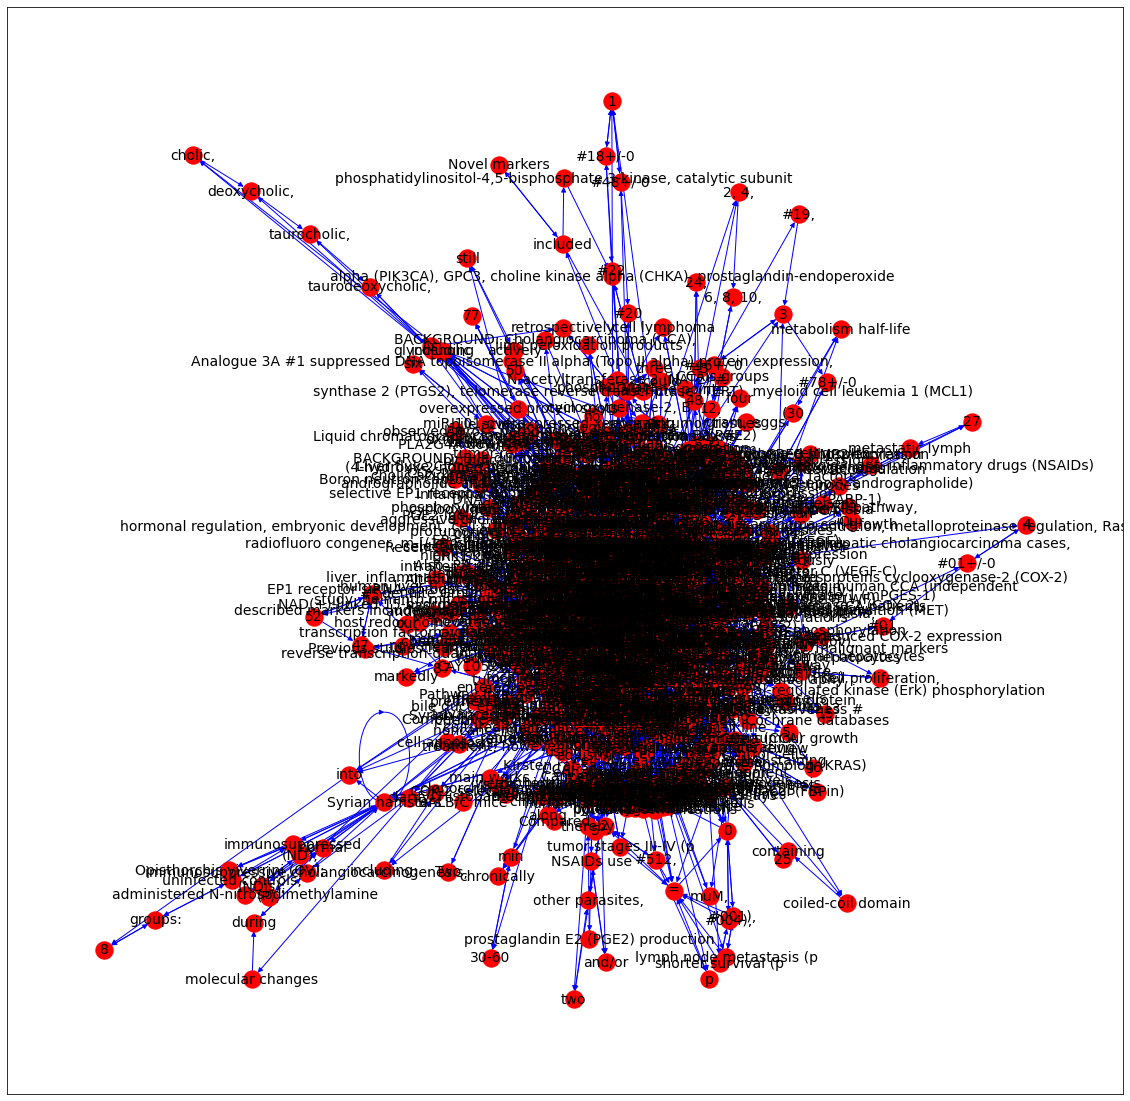

In [204]:
plot_network(g)
# Those nodes visible at the periphery refers to terms that are unimportant.
# The central dense area is occupied by nodes that are well connected.
# Those well-connected nodes would suggests they are mentioned more often in article concerning cholangiocarcinoma.
# The number of incoming and outgoing edges would indicate which node is more important.

In [92]:
len(g.nodes)

944

In [182]:
# In order to compute the importance of a node, the HITS algorithm would compute
# two numbers for a node. 
# Authorities estimates the node value based on the incoming links. 
# Hubs estimates the node value based on outgoing links.
h, a = nx.hits(g)

/Users/simontse/miniconda3/envs/stanza/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [183]:
len(h), len(a)

(944, 944)

In [188]:
# Remove common English words that are irrelevant to the study
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
keys = [key for key in h.keys() if (len(wn.synsets(key.lower()))==0 and key.lower() not in stop_words) and '#' not in key and '+/-' not in key] # Remove common English words
len(keys)

534

In [191]:
node_connectivity = dict()
for key in keys:
    node_connectivity[key] = [h[key], a[key], round(h[key]/a[key],4), round(a[key]/h[key],4)]

In [205]:
# Out > In suggests the entity is a Subj more often than Obj
# In > Out suggests the entity is a Obj more often than Subj
for i in ['COX2', 'COX-2']:
    for key in node_connectivity.keys():
        if i in key:
            print (key)
            print ('Out > In ratio:', node_connectivity[key][2])
            print ('In > Out ratio:', node_connectivity[key][3])
            print ()

COX2
Out > In ratio: 0.4428
In > Out ratio: 2.2583

liver, inflammation-associated cytokine IL-6, lipid peroxidation-related proteins cyclooxygenase-2 (COX-2)
Out > In ratio: 4.6569
In > Out ratio: 0.2147

COX-2,
Out > In ratio: 2.5907
In > Out ratio: 0.386

COX-2 overexpressed CCA cells
Out > In ratio: 3.6197
In > Out ratio: 0.2763

cyclooxygenase-2 (COX-2) inhibitor, celecoxib,
Out > In ratio: 3.5281
In > Out ratio: 0.2834

COX-2 expression, proliferation
Out > In ratio: 2.2209
In > Out ratio: 0.4503

COX-2 enzyme
Out > In ratio: 6.2113
In > Out ratio: 0.161

COX-2 selective boron carrier, fenbufen boronopinacol (FBPin)
Out > In ratio: 0.4474
In > Out ratio: 2.2349

vascular endothelial growth factor-C (VEGF-C), cyclooxygenase-2 (COX-2),
Out > In ratio: 5.1845
In > Out ratio: 0.1929

high COX-2 expression levels
Out > In ratio: 0.4098
In > Out ratio: 2.44

conjugated bile acid (taurocholate, (TCA))-induced COX-2 expression
Out > In ratio: 0.6998
In > Out ratio: 1.4289

reduced COX-2 